In [724]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [737]:
L = 5 #system size
M = 0.1 #fermion mass
N=5 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [738]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |2 2 2 2 2>           242  
       1.         |2 2 2 2 1>           241  
       2.         |2 2 2 2 0>           240  
       3.         |2 2 2 1 2>           239  
       4.         |2 2 2 1 1>           238  
       5.         |2 2 2 1 0>           237  
       6.         |2 2 2 0 2>           236  
       7.         |2 2 2 0 1>           235  
       8.         |2 2 2 0 0>           234  
       9.         |2 2 1 2 2>           233  
      10.         |2 2 1 2 1>           232  
      11.         |2 2 1 2 0>           231  
      12.         |2 2 1 1 2>           230  
      13.         |2 2 1 1 1>           229  
      14.         |2 2 1 1 0>           228  
      15.         |2 2 1 0 2>           227  
      16.         |2 2 1 0 1>           226  
      17.         |2 2 1 0 0>           225  
      18.         |2 2 0 2 2>           224  
      19.         |2 2 0 2 1>           223  
      20.  

In [739]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [740]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [741]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [742]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [743]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
b = np.zeros(2*l+1)
for i in range(2*l+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [744]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []
interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])
    quartic_term.append([[(x[4])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1]])
    quintic_term.append([[(x[5])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1]])
    sextic_term.append([[(x[6])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1,i+1]])

    const_term

    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],
        ["+zzzz", quartic_term[i]],
        ["+zzzzz", quintic_term[i]],
        ["+zzzzzz", sextic_term[i]],

    ])

    interaction_m.append([
        ["-", const_term[i]],
        ["-z", linear_term[i]],
        ["-zz", quadratic_term[i]],
        ["-zzz", cubic_term[i]],
        ["-zzzz", quartic_term[i]],
        ["-zzzzz", quintic_term[i]],
        ["-zzzzzz", sextic_term[i]],

    ])

const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**(i)*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

G=0
for i in range(L+1):
    G += 0.3*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term
#print(full_ham_matrix)

In [745]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])
print(eigenvec[:,0])

[-1.0416023  -0.34551385 -0.34551385]
[-2.53163065e-03-3.24505078e-03j  2.09753842e-18+2.12234376e-17j
  9.33024369e-18-6.13452888e-18j -9.47235509e-03-1.21416895e-02j
  1.77072160e-02+2.26971556e-02j -3.39734352e-18+5.95140717e-19j
 -7.52586878e-20+8.19929368e-18j -9.42470961e-18+5.73759790e-18j
 -1.19073526e-17-2.58251935e-17j  5.79251217e-18-2.94733121e-18j
 -9.22134350e-19-6.53664308e-19j -3.63326158e-19-1.06345376e-19j
  1.16592433e-17+1.59517137e-17j -1.26450165e-17-4.14119467e-18j
  1.04736035e-18-1.34864829e-19j  9.85832768e-18-6.93739547e-18j
  9.85219883e-18+1.48296720e-17j -9.75889174e-19-1.23214684e-17j
  1.47928794e-17+2.46331403e-17j  2.10687902e-19-1.40997670e-19j
  3.17788432e-18-3.14943581e-18j -5.99057979e-18+1.38786790e-17j
 -4.58718185e-18+1.35670676e-17j -2.54906861e-18-1.46504847e-19j
 -4.84205266e-18+1.75231444e-18j -9.86297155e-18+7.51288031e-18j
 -6.32017212e-18+1.66148377e-17j -9.47235509e-03-1.21416895e-02j
  1.00002669e-17-6.74196639e-18j -1.37820261e-17-2.5

In [746]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian with the local contstaints
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [747]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-1.0416023  -0.0142565   0.15174042]
(0.0014844734224547817-0.003838729865713476j)|2 2 2 2 2>
(0.005554309176844463-0.01436300050781745j)|2 2 2 1 2>
(-0.01038298830666227+0.026849579591818405j)|2 2 2 1 1>
(0.005554309176844554-0.014363000507817416j)|2 1 2 2 2>
(0.02636398478491669-0.06817516180634561j)|2 1 2 1 2>
(-0.051377740139318395+0.1328587380025486j)|2 1 2 1 1>
(-0.05178621202369917+0.13391501371497025j)|2 1 1 1 2>
(0.11325934217076458-0.29287962504779286j)|2 1 1 1 1>
(-0.042705381114064814+0.1104327092890265j)|2 1 1 0 1>
(-0.010382988306662535+0.026849579591818273j)|1 1 2 2 2>
(-0.051377740139318936+0.1328587380025485j)|1 1 2 1 2>
(0.10088170207651978-0.26087203503095197j)|1 1 2 1 1>
(0.11325934217076553-0.29287962504779164j)|1 1 1 1 2>
(-0.2486361291431301+0.6429531982181247j)|1 1 1 1 1>
(0.09527977162355326-0.246385889701456j)|1 1 1 0 1>
(-0.04270538111406554+0.110432709289026j)|1 0 1 1 2>
(0.09527977162355392-0.24638588970145536j)|1 0 1 1 1>
(-0.04053742920343548+0.104826558

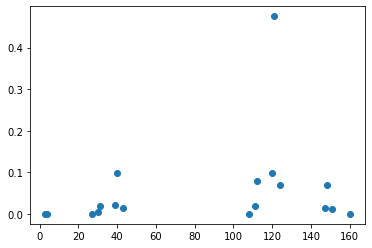

In [748]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")

In [608]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [544]:
#cost function of the initial state
expt_value = 0
matvec_h = full_ham_matrix@psi_0
matvec_c = constraint_full_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*(matvec_h[i]+matvec_c[i])
print(np.real(expt_value))

0.0


In [545]:
expt_value = 0
matvec = full_ham_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*matvec[i]
print(expt_value)

0j


In [546]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma/2)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms(k,i,j,phi,theta):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    power_matrix = scipy.sparse.kron(sigma,sparse.identity(2*l+1))+scipy.sparse.kron(sparse.identity(2*l+1),sigma)
    rot_matrix = scipy.sparse.linalg.expm(-1j*power_matrix@power_matrix*theta/4)
    if k == 0:
        tensprod = rot_matrix
        for i in range(L-2):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+2,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms_e(i,j,phi,theta):
    ms_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        ms_e = rot_ms(2*k,i,j,phi,theta)@ms_e
    return(ms_e)

def rot_ms_o(i,j,phi,theta):
    ms_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)-1):
        ms_o = rot_ms(2*k+1,i,j,phi,theta)@ms_o
    return(ms_o)

def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_all(i,j,phi,theta):
    sigma_all = sparse.identity(basis.Ns,dtype = complex)
    for k in range(L):
        sigma_all = rot_sigma(k,i,j,phi,theta)@sigma_all
    return(sigma_all)

In [547]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta/4)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    

In [548]:
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
b = rot_sigma_e(0,1,0,np.pi)
print(datetime.datetime.now())
a@b
print(datetime.datetime.now())

2022-04-07 15:22:20.644609
2022-04-07 15:22:20.652366
2022-04-07 15:22:20.669583
2022-04-07 15:22:20.671405


In [549]:

def sigma_sigma(m,n,theta):
    sigma_sigma = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    temp1 = np.cos(theta/2)
    temp2 = -1j*np.sin(theta/2)
    for i in range(basis.Ns):
        sigma_sigma[i,i] = 1.
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

            
    return sigma_sigma

def id_id(m,theta):
    id_id = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        id_id[i,i] = 1.
        
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4))
            
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4)) 
            
    return id_id


def ms_global_sparse(theta):
    ms_global = sparse.identity(basis.Ns)
    for m in range(L):
        ms_global = id_id(m,theta)@ms_global
        for n in range(m+1,L):
            ms_global = sigma_sigma(m,n,theta)@ms_global
    return ms_global

#print(np.allclose(ms_global_sparse(np.pi/4).toarray(),ms_gate_global(np.pi/4), atol= 1e-3,rtol=1e-3))
#print(np.allclose(ms_global_sparse(np.pi/3).toarray().conj().T@ms_global_sparse(np.pi/3).toarray(),np.identity(basis.Ns), atol= 1e-8,rtol=1e-8))

%time sigma_sigma(0,1,np.pi/3)

CPU times: user 38.3 ms, sys: 53 µs, total: 38.4 ms
Wall time: 36.6 ms


<243x243 sparse matrix of type '<class 'numpy.complex128'>'
	with 351 stored elements in List of Lists format>

In [550]:
#import timeit
#print(timeit.timeit('[ms_gate_global(0,2,np.pi)]', globals=globals()))
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
print(np.size(a))


2022-04-07 15:22:21.680800
2022-04-07 15:22:21.683665
59049


In [551]:
def cost_function_sigma(theta):
    psi_var = psi_0
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

import datetime

print(datetime.datetime.now())
a = cost_function_sigma(np.pi*np.ones(5*N))
print(datetime.datetime.now())

2022-04-07 15:22:22.174072
2022-04-07 15:22:22.437695


In [552]:
opt_params = []
function_values = []
def callback_function(x,fun,context):
    opt_params.append(x)
    function_values.append(fun)


In [553]:
full_ham_matrix = sparse.csc_matrix(full_ham_matrix)

In [554]:
Energy = np.zeros(5)
Fidelity = np.zeros(5)

In [556]:
import optuna
#for N in range(1,6):
theta = np.zeros(5*N)
#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[5*i+0] = trial.suggest_float("5*"+str(i)+"+0", -3*np.pi, 3*np.pi)
        theta[5*i+1] = trial.suggest_float("5*"+str(i)+"+1", -3*np.pi, 3*np.pi)
        theta[5*i+2] = trial.suggest_float("5*"+str(i)+"+2", -3*np.pi, 3*np.pi)
        theta[5*i+3] = trial.suggest_float("5*"+str(i)+"+3", -3*np.pi, 3*np.pi)
        theta[5*i+4] = trial.suggest_float("5*"+str(i)+"+4", -3*np.pi, 3*np.pi)


        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(1,2,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

if __name__ == "__main__":
    sampler = optuna.samplers.CmaEsSampler()
    study = optuna.create_study(sampler=sampler)
    study.optimize(cost_function_sigma, n_trials=3000)
    

"""""""""""""""""""""
k=0
for value in study.best_trial.params.items():
    theta[k] = value[1]
    k+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    #Energy[N-1] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var)
    #Fidelity[N-1] = np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2
"""""""""""""""""""""

[I 2022-04-07 15:24:03,846] A new study created in memory with name: no-name-43e49ce1-1312-4f9f-b1c1-b64c30a0ba34
[I 2022-04-07 15:24:04,060] Trial 0 finished with value: 8.694029112550673 and parameters: {'5*0+0': 7.1145493761674246, '5*0+1': 7.306629431906362, '5*0+2': 6.584221793627616, '5*0+3': -3.1866730375762575, '5*0+4': 6.2158677959074105, '5*1+0': -5.106625189090589, '5*1+1': -5.339978786196489, '5*1+2': -7.984768499150477, '5*1+3': -4.981516482510484, '5*1+4': -3.6378345307151143, '5*2+0': -0.0946823215885324, '5*2+1': -4.398740343501751, '5*2+2': 6.767316164129721, '5*2+3': 7.237115462372042, '5*2+4': -2.860990842393977, '5*3+0': 0.5312729144866957, '5*3+1': -8.936556400079667, '5*3+2': 3.889205218415583, '5*3+3': -9.23101216810707, '5*3+4': -7.263482330490582, '5*4+0': 9.005117048162187, '5*4+1': 0.39133942034433744, '5*4+2': -2.7618869038990024, '5*4+3': 9.389306277600909, '5*4+4': -1.1170877786353444}. Best is trial 0 with value: 8.694029112550673.
[I 2022-04-07 15:24:04,

[I 2022-04-07 15:24:05,944] Trial 10 finished with value: 6.039477410687799 and parameters: {'5*0+0': -0.5211282018402411, '5*0+1': -2.5262654510147233, '5*0+2': -2.643941383883043, '5*0+3': -1.2909464263492085, '5*0+4': -4.582523553907881, '5*1+0': -2.8360891984143914, '5*1+1': 3.9889231616866767, '5*1+2': -1.973306178220911, '5*1+3': -4.322156169857812, '5*1+4': -0.05768391228594976, '5*2+0': 2.5651564984702944, '5*2+1': -0.6436097283441276, '5*2+2': -3.3975278882231366, '5*2+3': -2.5396327631746924, '5*2+4': -1.4097589897144063, '5*3+0': 3.692186781028018, '5*3+1': -2.9460532379864253, '5*3+2': -2.8266554105009742, '5*3+3': 3.300454427384307, '5*3+4': -8.690711251644473, '5*4+0': -2.414533170352364, '5*4+1': 7.182806517650282, '5*4+2': 1.0070067707011963, '5*4+3': -1.7387863583897425, '5*4+4': 0.3571961747743946}. Best is trial 10 with value: 6.039477410687799.
[I 2022-04-07 15:24:06,128] Trial 11 finished with value: 10.740044584042087 and parameters: {'5*0+0': -2.478237626217422, 

[I 2022-04-07 15:24:08,050] Trial 20 finished with value: 5.060303004782396 and parameters: {'5*0+0': 2.9334057559718008, '5*0+1': 2.245390463038274, '5*0+2': 1.750389420247835, '5*0+3': 1.278608217457524, '5*0+4': 0.45785634539204534, '5*1+0': 0.8508182909916867, '5*1+1': 7.443903854618885, '5*1+2': 3.4331157679094293, '5*1+3': 2.1944762671031097, '5*1+4': 0.9908947129786857, '5*2+0': -4.065343457652485, '5*2+1': -1.7331826381142, '5*2+2': -3.63692741441693, '5*2+3': -1.335043537385992, '5*2+4': -0.6235712121510335, '5*3+0': -0.7937482100068793, '5*3+1': 2.9410622061826195, '5*3+2': -4.882619708506561, '5*3+3': 0.6680644814827026, '5*3+4': -1.4394196633564076, '5*4+0': -0.8074360481365864, '5*4+1': 1.1321265036970982, '5*4+2': -4.045011915040395, '5*4+3': -0.19938084256240451, '5*4+4': -1.0240482199220602}. Best is trial 18 with value: 4.9530735368673575.
[I 2022-04-07 15:24:08,245] Trial 21 finished with value: 5.806102984065609 and parameters: {'5*0+0': 2.530021691105242, '5*0+1': -

[I 2022-04-07 15:24:10,405] Trial 30 finished with value: 6.151491761352578 and parameters: {'5*0+0': 2.57713620237163, '5*0+1': -0.8969401044768188, '5*0+2': 2.716173515593155, '5*0+3': -3.515643893797053, '5*0+4': -1.7495069769275333, '5*1+0': 7.230728628359301, '5*1+1': -1.504983436723461, '5*1+2': 7.2933273772956975, '5*1+3': 1.4163527394352409, '5*1+4': 2.617092866281327, '5*2+0': 0.16683134153910173, '5*2+1': -1.8709509649211067, '5*2+2': 0.7764965142402616, '5*2+3': 1.3805209316044604, '5*2+4': -2.5648513864012887, '5*3+0': 0.30870870647300097, '5*3+1': -3.7153453455727554, '5*3+2': -0.9038627838821081, '5*3+3': 1.3930582943012053, '5*3+4': -7.68783213273346, '5*4+0': 5.086767846001425, '5*4+1': 1.1883529427359814, '5*4+2': 9.34292878111132, '5*4+3': -2.8493976625620956, '5*4+4': 3.6146466620328432}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:10,688] Trial 31 finished with value: 6.952471635617147 and parameters: {'5*0+0': 2.740318718051553, '5*0+1': 1.

[I 2022-04-07 15:24:13,263] Trial 40 finished with value: 10.450453114045256 and parameters: {'5*0+0': -1.8239426958274614, '5*0+1': 0.6999998914551964, '5*0+2': 4.764541212649337, '5*0+3': -4.758417803127135, '5*0+4': -0.6662384638413423, '5*1+0': 4.537892229879204, '5*1+1': 4.065560345230526, '5*1+2': 0.8345995268759543, '5*1+3': -5.774498020218192, '5*1+4': -0.7359864308969959, '5*2+0': 2.4006318000321727, '5*2+1': -3.355622973114984, '5*2+2': 3.231548388520614, '5*2+3': -2.2909508715625906, '5*2+4': -0.7243802486714079, '5*3+0': 1.31803491973, '5*3+1': -1.6753492379955084, '5*3+2': -2.679359191627833, '5*3+3': 3.8566491592910497, '5*3+4': -5.7295482921980785, '5*4+0': -1.5921298554254968, '5*4+1': 1.0695123407603804, '5*4+2': 3.968112974360229, '5*4+3': -4.196742528719346, '5*4+4': -0.21426650602774255}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:13,509] Trial 41 finished with value: 5.293099309237768 and parameters: {'5*0+0': -2.5742930566200846, '5*0+1':

[I 2022-04-07 15:24:16,061] Trial 50 finished with value: 8.546280979415732 and parameters: {'5*0+0': -4.375004571323781, '5*0+1': 1.5615669506014154, '5*0+2': 2.7207864508428945, '5*0+3': -3.425908471504561, '5*0+4': -2.2279286499791873, '5*1+0': 2.3633929703834022, '5*1+1': -4.796043970765267, '5*1+2': 8.218614593546063, '5*1+3': 0.45059848685456044, '5*1+4': 6.1301391174295805, '5*2+0': 1.7418083323889595, '5*2+1': 1.1631888556832322, '5*2+2': 1.8097053348138117, '5*2+3': 6.377712793365341, '5*2+4': -2.683734780794052, '5*3+0': -0.2245782384878776, '5*3+1': -6.49354011869362, '5*3+2': -4.123782092794594, '5*3+3': 0.10484712635841964, '5*3+4': -0.3722510268743533, '5*4+0': 1.055148773836523, '5*4+1': 2.6867686610395127, '5*4+2': 6.701057737559406, '5*4+3': -4.459564005924938, '5*4+4': -1.506430583294176}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:16,315] Trial 51 finished with value: 10.137051651227196 and parameters: {'5*0+0': -2.8494064155760306, '5*0+1':

[I 2022-04-07 15:24:18,769] Trial 60 finished with value: 15.868111087944342 and parameters: {'5*0+0': 1.1787291563933873, '5*0+1': 4.445677538714477, '5*0+2': 1.2899155729361675, '5*0+3': -3.8173266180637495, '5*0+4': 0.1919681952777882, '5*1+0': -3.7823318774550674, '5*1+1': -1.325087525188745, '5*1+2': 8.047995426421897, '5*1+3': -1.414677037206814, '5*1+4': 3.892213251768541, '5*2+0': 2.8937437655252767, '5*2+1': -4.607266277243172, '5*2+2': -3.157310648922112, '5*2+3': -2.6083181575255594, '5*2+4': -2.0161933578278726, '5*3+0': -4.077238209176098, '5*3+1': -3.635899206674253, '5*3+2': -5.437897113642919, '5*3+3': 2.2289124093320143, '5*3+4': -5.587151266283366, '5*4+0': 7.708604230238478, '5*4+1': 0.7235630757471825, '5*4+2': 5.279341427413289, '5*4+3': -0.3810975454936387, '5*4+4': -1.69792362082941}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:19,083] Trial 61 finished with value: 6.525084572136263 and parameters: {'5*0+0': -2.883717704419511, '5*0+1': -

[I 2022-04-07 15:24:21,533] Trial 70 finished with value: 8.057486994298358 and parameters: {'5*0+0': -2.886046695676871, '5*0+1': -2.6160342421712612, '5*0+2': 1.962258293766522, '5*0+3': -2.9544844414375047, '5*0+4': 0.07710798781810335, '5*1+0': -4.330063551189319, '5*1+1': 2.9008325344710424, '5*1+2': 4.208723391355207, '5*1+3': -3.0691646934444003, '5*1+4': -0.40423665389111996, '5*2+0': 1.9191985377697207, '5*2+1': -5.0694497217804235, '5*2+2': -1.7671315922816804, '5*2+3': -0.19599911985828067, '5*2+4': -7.375713884720296, '5*3+0': 2.2878795473717854, '5*3+1': -4.566708306458231, '5*3+2': -5.674672526312573, '5*3+3': 6.047139936447156, '5*3+4': -7.24647491973988, '5*4+0': 4.637730417639851, '5*4+1': 0.09459990839724886, '5*4+2': 1.5975058698946276, '5*4+3': 0.8427214647558962, '5*4+4': -5.157742012343543}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:21,802] Trial 71 finished with value: 12.57874482618344 and parameters: {'5*0+0': -1.692716192791476, '5*0

[I 2022-04-07 15:24:24,215] Trial 80 finished with value: 5.347028652824461 and parameters: {'5*0+0': 3.860166404734152, '5*0+1': -0.7333924069009221, '5*0+2': 1.8711577365060705, '5*0+3': 1.415629245002533, '5*0+4': 3.4013530473345828, '5*1+0': -1.4088190166083274, '5*1+1': -3.0438704762343134, '5*1+2': 0.015443504921669904, '5*1+3': -1.1348700725729222, '5*1+4': -0.39289796786377185, '5*2+0': -0.8367796754037471, '5*2+1': -1.2661639007910421, '5*2+2': -0.3561588408660369, '5*2+3': 1.0656762005455174, '5*2+4': -5.207524512717662, '5*3+0': -6.59312281098865, '5*3+1': -5.339455864088315, '5*3+2': -2.006374094614125, '5*3+3': 9.032039447274766, '5*3+4': -3.365269500845425, '5*4+0': 2.6399529180889814, '5*4+1': 4.901913528021611, '5*4+2': 1.0354766854497173, '5*4+3': 2.6661109219062404, '5*4+4': 1.6373726154964818}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:24,479] Trial 81 finished with value: 10.5834525008625 and parameters: {'5*0+0': -1.035567755160606, '5*0+

[I 2022-04-07 15:24:26,889] Trial 90 finished with value: 8.479944839459659 and parameters: {'5*0+0': -0.5289588362761171, '5*0+1': 3.307565075823072, '5*0+2': 3.5342521370007463, '5*0+3': 0.983103154149036, '5*0+4': 6.421995025694692, '5*1+0': -1.423665045576819, '5*1+1': 3.12790671797699, '5*1+2': 4.688619892304418, '5*1+3': -2.380464405985132, '5*1+4': 2.0938360363558, '5*2+0': 2.5491429956162266, '5*2+1': -4.840969897772155, '5*2+2': 0.43910947365261443, '5*2+3': 0.8581177580781041, '5*2+4': -5.030213078860916, '5*3+0': -6.778664855487617, '5*3+1': -7.675775893407513, '5*3+2': -5.748319468037662, '5*3+3': 3.1653724203188514, '5*3+4': -2.0565786375781476, '5*4+0': 3.93627978606976, '5*4+1': 2.1745844339023517, '5*4+2': 4.319082475610835, '5*4+3': 1.5548932385561083, '5*4+4': -3.355891404845866}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:27,130] Trial 91 finished with value: 6.504898213782777 and parameters: {'5*0+0': 1.0807050888281173, '5*0+1': 1.16382750

[I 2022-04-07 15:24:29,452] Trial 100 finished with value: 9.288498158028883 and parameters: {'5*0+0': -0.6018457986721457, '5*0+1': 0.10853758257175827, '5*0+2': 4.299868662994562, '5*0+3': -2.4577646893838514, '5*0+4': 8.468378901851827, '5*1+0': -0.193984723097687, '5*1+1': -0.9869834584880305, '5*1+2': 1.605663889699685, '5*1+3': -2.5295985446668245, '5*1+4': -1.3359282016284642, '5*2+0': -0.37898660450309296, '5*2+1': -5.582293493179261, '5*2+2': 3.198341681957798, '5*2+3': 2.067897263064845, '5*2+4': -3.435940794752329, '5*3+0': -7.185432378387052, '5*3+1': -8.600671694157063, '5*3+2': -1.6163245352736628, '5*3+3': 2.6472135688465914, '5*3+4': -6.819730008791627, '5*4+0': 0.6029691993073045, '5*4+1': 3.4231485510859816, '5*4+2': 1.09724669447952, '5*4+3': 3.8784095102501563, '5*4+4': -1.9296057881045476}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:29,708] Trial 101 finished with value: 10.805537924897973 and parameters: {'5*0+0': -0.7057225734819506, '5*

[I 2022-04-07 15:24:32,152] Trial 110 finished with value: 4.450418028489228 and parameters: {'5*0+0': -2.7103939806962014, '5*0+1': -0.29986806618531014, '5*0+2': 4.102537490468967, '5*0+3': -4.72517519999512, '5*0+4': 2.9764260270824763, '5*1+0': -2.885552024996505, '5*1+1': 0.2580336768805296, '5*1+2': -0.011884908711575826, '5*1+3': -7.278703416342351, '5*1+4': 4.148161399302712, '5*2+0': 1.3132385304224117, '5*2+1': -2.5834661233822005, '5*2+2': 1.7983328287913478, '5*2+3': 1.5759474906820845, '5*2+4': -4.890284573807363, '5*3+0': 0.4218508815863613, '5*3+1': -7.405531599856329, '5*3+2': -7.823814189105946, '5*3+3': -0.30099478039974414, '5*3+4': 2.0337801454405486, '5*4+0': 0.04334401740774907, '5*4+1': 0.4138191796566564, '5*4+2': 3.0998383456243706, '5*4+3': 9.161710165228484, '5*4+4': -0.5032170998211292}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:32,408] Trial 111 finished with value: 20.12972209441124 and parameters: {'5*0+0': 2.6527051883272716, '

[I 2022-04-07 15:24:34,881] Trial 120 finished with value: 4.873308948462683 and parameters: {'5*0+0': 2.58363050065547, '5*0+1': 6.58848398432392, '5*0+2': 4.401541951118251, '5*0+3': -3.3850004068082544, '5*0+4': 5.499376225520276, '5*1+0': -3.7442199533692397, '5*1+1': 0.5133847934438847, '5*1+2': -3.404779064079185, '5*1+3': -6.355064701989223, '5*1+4': -0.3734835190740893, '5*2+0': 0.12051369903461273, '5*2+1': -3.2945545712819335, '5*2+2': -0.978994563261194, '5*2+3': 1.4646626151389077, '5*2+4': -5.150078127950375, '5*3+0': -1.454292202929674, '5*3+1': -2.9290157367556238, '5*3+2': -8.025204765117493, '5*3+3': 2.9789671598189593, '5*3+4': 3.6319177348414096, '5*4+0': 0.04271418630113821, '5*4+1': 0.8354142957959225, '5*4+2': -1.2150983875095356, '5*4+3': 4.892464250108498, '5*4+4': -7.654662062025109}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:35,158] Trial 121 finished with value: 9.7911774193769 and parameters: {'5*0+0': 1.7560846802721486, '5*0+1': 

[I 2022-04-07 15:24:37,559] Trial 130 finished with value: 9.83174797502512 and parameters: {'5*0+0': 1.3703061505673397, '5*0+1': 3.0502252763887645, '5*0+2': 2.002440769610186, '5*0+3': 1.943475001943777, '5*0+4': 5.592418423391249, '5*1+0': -4.291243228695423, '5*1+1': 2.9009189582217205, '5*1+2': 1.1499997869867153, '5*1+3': -7.355797459228208, '5*1+4': 0.21565469214368904, '5*2+0': 1.2268268221746197, '5*2+1': -0.0896578465682718, '5*2+2': 2.1053885338973655, '5*2+3': 2.6148573991404906, '5*2+4': -5.457745142257086, '5*3+0': -2.7417043263786147, '5*3+1': -5.948673420744619, '5*3+2': -3.691818377629386, '5*3+3': 1.3063518016934426, '5*3+4': -2.5052491368412158, '5*4+0': -1.8980885270166281, '5*4+1': 3.308664741488945, '5*4+2': -1.379001104542509, '5*4+3': 6.979543755304371, '5*4+4': -6.228646942133855}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:37,830] Trial 131 finished with value: 4.8278856161713835 and parameters: {'5*0+0': 3.3579725343818554, '5*0+1':

[I 2022-04-07 15:24:40,168] Trial 140 finished with value: 6.849904962862038 and parameters: {'5*0+0': -2.2889936599339484, '5*0+1': 1.3225614305013056, '5*0+2': 2.498186930671453, '5*0+3': -5.740046652214187, '5*0+4': 2.2385881878458447, '5*1+0': -4.510033362352436, '5*1+1': 1.3870010894731386, '5*1+2': -2.9387263260954293, '5*1+3': -8.096962668229033, '5*1+4': 0.7628678393076102, '5*2+0': 4.537200921552027, '5*2+1': -1.6972241978126434, '5*2+2': 3.2049676172883355, '5*2+3': -1.7028058462237947, '5*2+4': -6.417658595459625, '5*3+0': -8.897632600704364, '5*3+1': -9.39264364724719, '5*3+2': -6.202813803752885, '5*3+3': 1.2022910497460337, '5*3+4': -3.3678581956144313, '5*4+0': 2.133258993750094, '5*4+1': -0.8067446768368532, '5*4+2': -5.828982526674942, '5*4+3': 7.994814492171066, '5*4+4': -5.634997407651828}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:40,422] Trial 141 finished with value: 10.432730977360432 and parameters: {'5*0+0': 1.5521052183851443, '5*0+1

[I 2022-04-07 15:24:43,012] Trial 150 finished with value: 7.822896322834303 and parameters: {'5*0+0': -0.9356647994997505, '5*0+1': 2.844359262618637, '5*0+2': 0.05620021031300859, '5*0+3': -9.060365754554496, '5*0+4': 2.2588769875326244, '5*1+0': -1.7910881329113502, '5*1+1': -5.645572553278831, '5*1+2': -2.7962442887963355, '5*1+3': -9.36051128999479, '5*1+4': 0.3832142949627487, '5*2+0': 2.0613974817564786, '5*2+1': -1.520031137153596, '5*2+2': -1.8862375632916533, '5*2+3': 6.454075550684385, '5*2+4': -2.822721885588829, '5*3+0': -7.564913502715693, '5*3+1': -4.712519871261703, '5*3+2': -4.850283522558161, '5*3+3': 0.7152541098178051, '5*3+4': -3.019961753470178, '5*4+0': 1.3446524987097868, '5*4+1': -1.2412798683406558, '5*4+2': 2.556447514838828, '5*4+3': 7.63958309418482, '5*4+4': -0.16217686531090303}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:43,314] Trial 151 finished with value: 8.190393239534082 and parameters: {'5*0+0': -1.1127866133732183, '5*0+

[I 2022-04-07 15:24:45,978] Trial 160 finished with value: 6.814573995693894 and parameters: {'5*0+0': -0.2359729297620392, '5*0+1': -2.5831550455295105, '5*0+2': -2.425522284827144, '5*0+3': 1.2465510176487182, '5*0+4': 3.054882592094544, '5*1+0': 0.9322055210018442, '5*1+1': 4.254710269853253, '5*1+2': -3.349934697563343, '5*1+3': -7.153892892884432, '5*1+4': -2.9315407637906366, '5*2+0': 0.2851669972260078, '5*2+1': 5.745513896072714, '5*2+2': 1.0077649310141006, '5*2+3': 3.223937456749976, '5*2+4': -6.339441702518883, '5*3+0': -3.166630486857266, '5*3+1': 0.9620708836242757, '5*3+2': -3.1778803328422245, '5*3+3': 5.8043985395601965, '5*3+4': -0.07381542956410336, '5*4+0': 4.666935487434928, '5*4+1': -0.8904813920854048, '5*4+2': -3.516753331256983, '5*4+3': 6.173461662339095, '5*4+4': -7.02419878030585}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:46,273] Trial 161 finished with value: 9.942656653079817 and parameters: {'5*0+0': -3.134410363593652, '5*0+1':

[I 2022-04-07 15:24:48,743] Trial 170 finished with value: 8.666571812155466 and parameters: {'5*0+0': 3.419582859993544, '5*0+1': 1.2579129510304343, '5*0+2': 1.0075548644163768, '5*0+3': -1.823680314204856, '5*0+4': 4.657848134101648, '5*1+0': 0.7440022855311403, '5*1+1': -1.4764135609496345, '5*1+2': -1.729158724310186, '5*1+3': -0.6994266453531415, '5*1+4': -4.846670580468334, '5*2+0': 1.6658927770396854, '5*2+1': 2.6641687444369113, '5*2+2': 6.502952641451132, '5*2+3': 0.1304780085807522, '5*2+4': -4.908702538002059, '5*3+0': -1.8125686529761236, '5*3+1': 0.3157840593663024, '5*3+2': -3.2311444959192657, '5*3+3': 0.866362934812613, '5*3+4': -0.3460207204103205, '5*4+0': 7.828195460559087, '5*4+1': 0.07703221076950506, '5*4+2': -0.5088924163184844, '5*4+3': 8.952069493999048, '5*4+4': -3.9040315847697746}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:49,093] Trial 171 finished with value: 8.76298204767138 and parameters: {'5*0+0': 1.9637110687643375, '5*0+1'

[I 2022-04-07 15:24:52,049] Trial 180 finished with value: 24.779978605656094 and parameters: {'5*0+0': 1.8139371110152172, '5*0+1': 8.261020458778932, '5*0+2': 0.2163223828594958, '5*0+3': -2.1416575012548265, '5*0+4': 5.729645139508163, '5*1+0': -0.8980097399258063, '5*1+1': -1.8159358989678769, '5*1+2': -0.8560325276317906, '5*1+3': -4.975729621850469, '5*1+4': -0.5348266746740635, '5*2+0': -0.033742477844231455, '5*2+1': 4.41890663257923, '5*2+2': 7.200945411286106, '5*2+3': -0.939591173534728, '5*2+4': -2.8140063506560895, '5*3+0': 0.5890074048462077, '5*3+1': -2.5081710998393154, '5*3+2': -4.189418670064106, '5*3+3': 3.8080704877408427, '5*3+4': 0.20160118233404623, '5*4+0': 2.626218132802286, '5*4+1': -2.132912880191804, '5*4+2': -5.835133622119368, '5*4+3': 8.6341758954873, '5*4+4': -6.332987237068078}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:52,321] Trial 181 finished with value: 8.820300520855248 and parameters: {'5*0+0': 0.9446552188909707, '5*0+

[I 2022-04-07 15:24:54,869] Trial 190 finished with value: 13.470471463240425 and parameters: {'5*0+0': 1.2448819166423772, '5*0+1': 2.1267914519923106, '5*0+2': -0.4554832747381544, '5*0+3': 3.4395590939134824, '5*0+4': 4.231891986040307, '5*1+0': -0.3585454352888997, '5*1+1': 1.8192765616109814, '5*1+2': -2.828691168186852, '5*1+3': -2.2746104682196924, '5*1+4': -0.05057582035076269, '5*2+0': -2.5157652120779015, '5*2+1': -0.31761574669221204, '5*2+2': 6.292295423004146, '5*2+3': 2.4363589172270883, '5*2+4': -5.008834911832405, '5*3+0': -3.464678704170061, '5*3+1': -1.9486306770878028, '5*3+2': -4.969053414730838, '5*3+3': 4.981355831843203, '5*3+4': -0.49746772183127197, '5*4+0': 4.3743444824980475, '5*4+1': 2.4039017489599264, '5*4+2': -3.6096792428271383, '5*4+3': 6.154356132796908, '5*4+4': -2.5234900426105353}. Best is trial 24 with value: 2.6533667165629504.
[I 2022-04-07 15:24:55,143] Trial 191 finished with value: 8.334952621906774 and parameters: {'5*0+0': 2.5920976419154718

KeyboardInterrupt: 

In [53]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):

    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(1,2,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.8237413874401839


In [ ]:
result = scipy.optimize.minimize(cost_function_sigma, theta, method='Nelder-Mead',options={'initial_simplex': None, 'xatol': 1e-6, 'fatol': 1e-4})

In [ ]:
print(result.fun)
print(result.x)

In [ ]:

string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

In [ ]:
string = ""
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

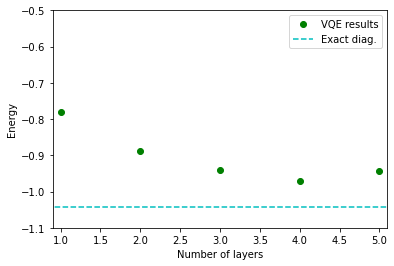

In [36]:
plt.plot(np.array([1,2,3,4,5]),Energy,'o', color = "green",label="VQE results")
plt.plot(np.array([0,1,2,3,4,5,6]),eigenvalues[0]*np.ones(7), ls = "--", color ="c", label = "Exact diag.")
plt.xlabel("Number of layers")
plt.ylabel("Energy")
plt.ylim(-1.1,-0.5)
plt.xlim(0.9,5.1)
plt.legend()

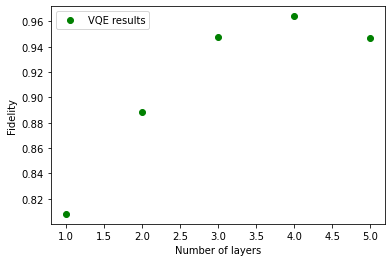

In [37]:
plt.plot(np.array([1,2,3,4,5]),Fidelity,'o', color = "green",label="VQE results")
plt.xlabel("Number of layers")
plt.ylabel("Fidelity")
plt.legend()